In [1]:
import os
import pickle
import subprocess

# Third-party
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pyia import GaiaData

import gala.coordinates as gc

# Custom
from matplotlib import cm
from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.stats import norm, truncnorm

from density import get_projected_coords, get_u_v, get_uniform_idx, GaussianNoodle2D
from likelihood import z_to_a, a_to_z, StreamDensityModel
from likelihood import ln_bg_quadratic_uniform, ln_d_ln_bg_quadratic_uniform_dp
from likelihood import ln_bg_uniform, ln_d_ln_bg_uniform_dp

In [2]:
gd1 = GaiaData('/Users/adrian/projects/gd1-dr2/data/gd1-better-selection.fits')

In [3]:
c = gd1.get_skycoord(distance=False)
c_gd1 = c.transform_to(gc.GD1)
ref_c = gc.GD1(phi1=0*u.deg, phi2=0*u.deg)

phi1 = c_gd1.phi1.wrap_at(180*u.deg).degree
phi2 = c_gd1.phi2.degree

In [4]:
X = get_projected_coords(c_gd1, ref_c).T

Compare projected vs. non-projected coordinates

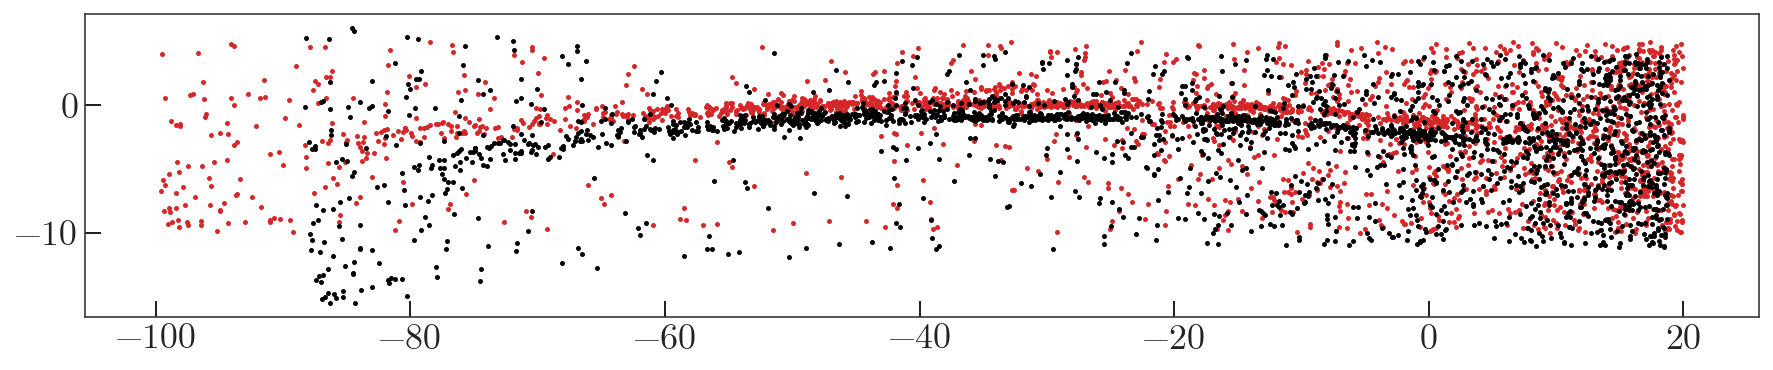

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(phi1, phi2, marker='.', ls='none', color='tab:red')
ax.plot(X[:, 0], X[:, 1], marker='.', ls='none', color='k')
ax.set_aspect('equal')

How much does the background vary?

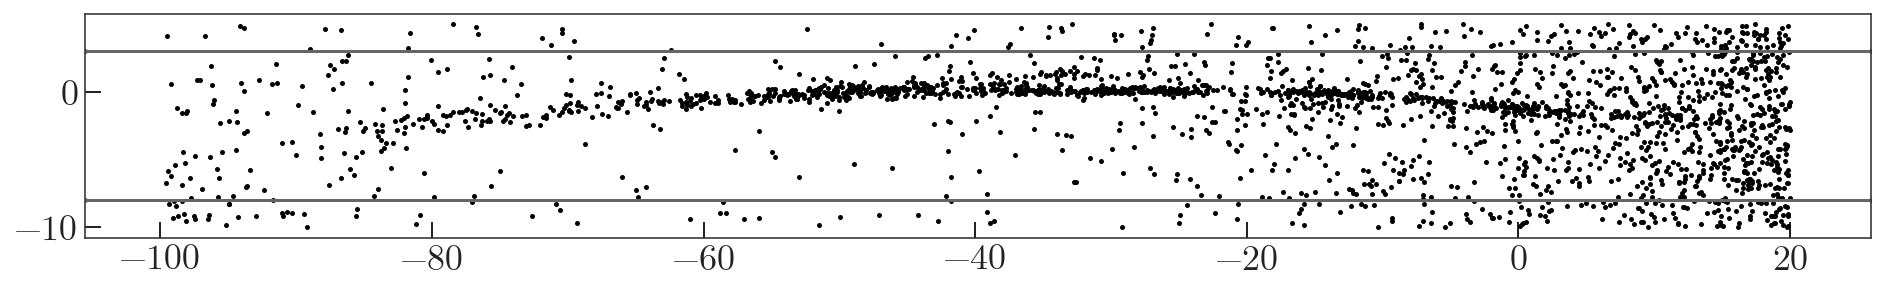

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 2.5))
ax.plot(phi1, phi2, marker='.', ls='none', color='k')
ax.set_aspect('equal')
ax.axhline(3)
ax.axhline(-8)

In [7]:
bg_mask1 = (phi2 > 3)
bg_mask2 = (phi2 < -8)

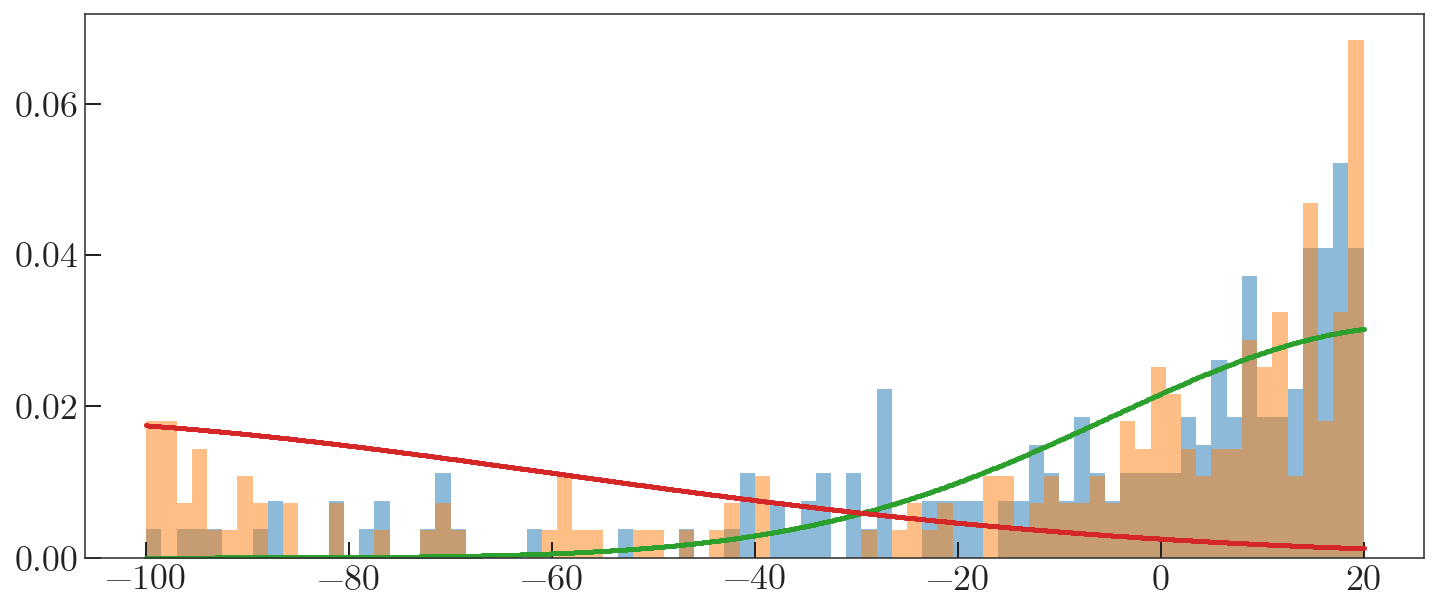

In [8]:
bins = np.arange(-100, 20+1e-3, 1.5)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(phi1[bg_mask1], bins=bins, alpha=0.5, density=True);
ax.hist(phi1[bg_mask2], bins=bins, alpha=0.5, density=True);

x_grid = np.linspace(-100, 20, 1024)

my_mean = 25.
my_std = 30.
myclip_a, myclip_b = (-100, 20)
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
ax.plot(x_grid, truncnorm.pdf(x_grid, a, b, loc=my_mean, scale=my_std))

my_mean = -120.
my_std = 60.
myclip_a, myclip_b = (-100, 20)
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
ax.plot(x_grid, truncnorm.pdf(x_grid, a, b, loc=my_mean, scale=my_std))

---

In [90]:
X = np.stack((phi1, phi2)).T
# window_bounds = [[-75, -50], 
window_bounds = [[-100, 20], 
                 [-10, 5]]
mask = ((X[:, 0] > window_bounds[0][0]) &
        (X[:, 0] < window_bounds[0][1]) &
        (X[:, 1] > window_bounds[1][0]) &
        (X[:, 1] < window_bounds[1][1]))
X = X[mask]

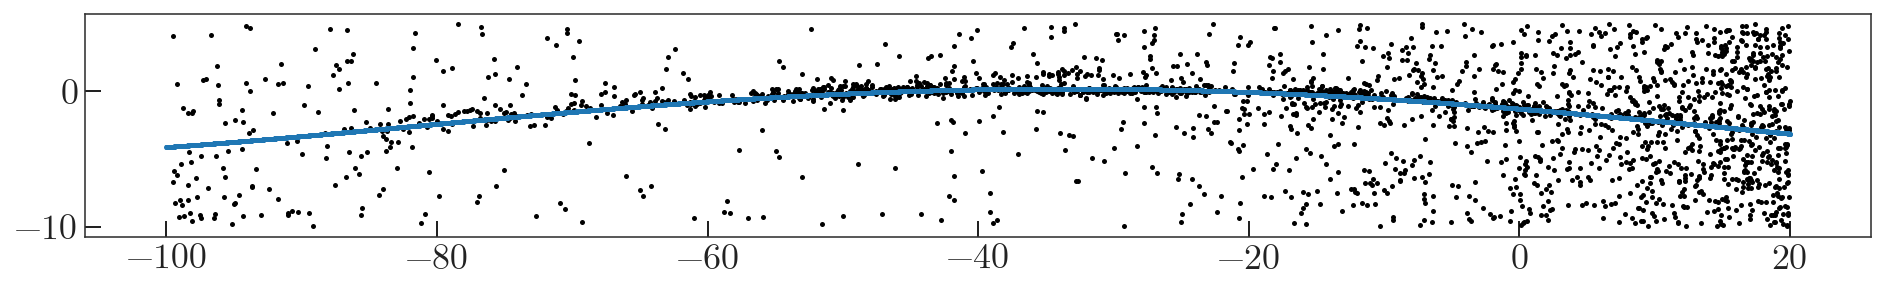

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(X[:, 0], X[:, 1], 
        marker='.', ls='none', color='k')

_fit_mask = ((X[:, 1] > -1) & (X[:, 1] < 1))
# poly = np.poly1d(np.polyfit(X[_fit_mask, 0], X[_fit_mask, 1], deg=2))

poly = np.poly1d(np.load('/Users/adrian/projects/gd1-dr2/output/polytrack.npy'))
_grid = np.linspace(window_bounds[0][0], 
                    window_bounds[0][1],
                    10000)
track = np.stack((_grid, poly(_grid))).T
ax.plot(track[:, 0], track[:, 1])

ax.set_aspect('equal')

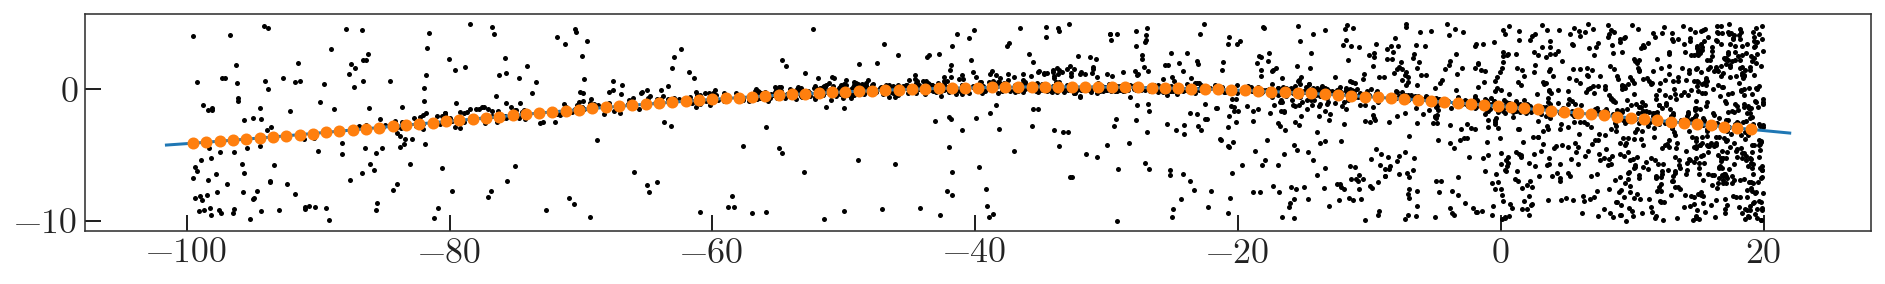

In [92]:
dens_model = GaussianNoodle2D(X, poly=poly)
track = dens_model.get_dense_poly_track(xgrid=np.linspace(X[:,0].min()-2,
                                                          X[:,0].max()+2,
                                                          10000))
spacing = 1
nodes = dens_model.set_nodes(track=track, spacing=spacing)

node_mask = ((nodes[:, 0] > window_bounds[0][0]) &
             (nodes[:, 0] < window_bounds[0][1]) &
             (nodes[:, 1] > window_bounds[1][0]) &
             (nodes[:, 1] < window_bounds[1][1]))
nodes = dens_model.set_nodes(track, nodes=nodes[node_mask])
K = dens_model.K

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.plot(X[:, 0], X[:, 1], 
        marker='.', ls='none', color='k')
ax.plot(track[:, 0], track[:, 1], marker='')
ax.scatter(nodes[:, 0], nodes[:, 1], 
           marker='o', color='tab:orange', zorder=10)

ax.set_aspect('equal')

In [93]:
def ln_bg_quadratic_uniform(p, X, window_bounds):
    a, b = window_bounds[0]
    x1, x2 = X.T
    N = len(x1)

    # x1 direction:
    c1 = np.exp(p['ln_bg_c1'])
    c2 = np.exp(p['ln_bg_c2'])
    c3 = np.exp(p['ln_bg_c3'])
    x0 = p['bg_x0']

    lnA = np.log(6) - np.log((b - a)*(2*a**2*c1 + 2*a*b*c1 + 2*b**2*c1 + 3*a*c2 + 3*b*c2 + 6*c3 - 6*a*c1*x0 - 6*b*c1*x0 - 6*c2*x0 + 6*c1*x0**2))
    ln_px1 = lnA + logsumexp([np.log(c1) + np.log((x1-x0)**2),
                              np.log(c2) + np.log(np.abs(x1-x0)),
                              np.full_like(x1, np.log(c3))],
                             b=[np.ones(N), np.sign(x1-x0), np.ones(N)],
                             axis=0)

    # x2 direction:
    ln_px2 = -np.log(window_bounds[1][1] - window_bounds[1][0])

    return ln_px1 + ln_px2


def ln_d_ln_bg_quadratic_uniform_dp(p, X, window_bounds):
    a, b = window_bounds[0]
    x, x2 = X.T
    N = len(x)

    c1 = np.exp(p['ln_bg_c1'])
    c2 = np.exp(p['ln_bg_c2'])
    c3 = np.exp(p['ln_bg_c3'])
    x0 = p['bg_x0']

    derivs = dict()
    signs = dict()

    derivs['ln_bg_c1'] = ((6*(2*a**2*(c3 + c2*(x - x0)) + 2*b**2*(c3 + c2*(x - x0)) -
                          6*x*(c3*(x - 2*x0) + c2*x0*(-x + x0)) - 3*b*(2*c3*x0 + c2*(x - x0)*(x + x0)) +
                          a*(-3*c2*x**2 - 6*c3*x0 + 3*c2*x0**2 + 2*b*(c3 + c2*x - c2*x0)))) /
                        ((a - b)*(2*a**2*c1 + 2*a*b*c1 + 2*b**2*c1 + 3*a*c2 + 3*b*c2 + 6*c3 -
                                  6*((a + b)*c1 + c2)*x0 + 6*c1*x0**2)**2))

    derivs['ln_bg_c2'] = ((6*(2*a**2*c1*(-x + x0) + 2*b**2*c1*(-x + x0) - 6*x*(c3 + c1*(x - x0)*x0) +
   3*b*(c3 + c1*(x - x0)*(x + x0)) + a*(3*c3 + c1*(x - x0)*(-2*b + 3*(x + x0)))))/
 ((a - b)*(2*a**2*c1 + 2*a*b*c1 + 2*b**2*c1 + 3*a*c2 + 3*b*c2 + 6*c3 -
    6*((a + b)*c1 + c2)*x0 + 6*c1*x0**2)**2))

    derivs['ln_bg_c3'] = ((-6*(2*a**2*c1 + 2*b**2*c1 + 3*b*c2 + a*(2*b*c1 + 3*c2) - 6*x*(c2 + c1*x)) +
  36*c1*(a + b - 2*x)*x0)/((a - b)*(2*a**2*c1 + 2*a*b*c1 + 2*b**2*c1 + 3*a*c2 + 3*b*c2 +
    6*c3 - 6*((a + b)*c1 + c2)*x0 + 6*c1*x0**2)**2))

    derivs['bg_x0'] = ((6*(6*(c2 + c1*(a + b - 2*x0))*(c3 + (c2 + c1*(x - x0))*(x - x0)) -
   (c2 + 2*c1*(x - x0))*(2*a**2*c1 + 2*a*b*c1 + 2*b**2*c1 + 3*a*c2 + 3*b*c2 + 6*c3 -
     6*((a + b)*c1 + c2)*x0 + 6*c1*x0**2)))/
 ((-a + b)*(2*a**2*c1 + 2*a*b*c1 + 2*b**2*c1 + 3*a*c2 + 3*b*c2 + 6*c3 -
    6*((a + b)*c1 + c2)*x0 + 6*c1*x0**2)**2))

    # because it's multiplied in the likelihood
    ln_px2 = -np.log(window_bounds[1][1] - window_bounds[1][0])

    for name in ['ln_bg_c1', 'ln_bg_c2', 'ln_bg_c3', 'bg_x0']:
        signs[name] = np.sign(derivs[name])
        derivs[name] = np.log(np.abs(derivs[name])) + ln_px2
        
        if 'bg_c' in name:
            derivs[name] = derivs[name] + p[name]

    return derivs, signs

In [140]:
bg_params = {'ln_bg_c1': (1,),
             'ln_bg_c2': (1,),
             'ln_bg_c3': (1,),
             'bg_x0': (1,)}
model = StreamDensityModel(X, dens_model, h=1.5*spacing, 
                           bg_ln_likelihood=ln_bg_quadratic_uniform, 
                           d_bg_ln_likelihood_dp=ln_d_ln_bg_quadratic_uniform_dp,
                           bg_params=bg_params, 
                           bg_kwargs=dict(window_bounds=window_bounds),
                           m_prior_sigma=0.5,
                           frozen={'ln_bg_c2': -np.inf,
                                   'ln_bg_c3': -np.inf})
#                            frozen={'m': np.zeros(K)})

# bg_ln_likelihood=ln_bg_uniform, 
# d_bg_ln_likelihood_dp=ln_d_ln_bg_uniform_dp,
# bg_params = dict()

In [141]:
# seems like a good initialization: (with c2, c3 = 0)
bg_p0 = {'ln_bg_c1': np.log(1e3),
         'bg_x0': -50.}

In [142]:
f0 = 0.5
sk0 = np.ones(K)
z0 = a_to_z(np.ones(K)/K)
m0 = np.zeros(K)
m0 = 1e-3 * np.ones(K)

p0 = {'ln_s': np.log(sk0),
      'ln_z': np.log(z0),
      'm': m0,
      'f': f0}
p0.update(bg_p0)

x0 = model.pack_pars(p0, fill_frozen=False)
x0

array([-5.00000000e+01,  5.00000000e-01,  6.90775528e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [143]:
def func_helper(x):
    p = model.unpack_pars(x)
    # ll = model.ln_likelihood(p)
    
    # if 'm' not in model.frozen:
    #     ll = ll - np.sum(p['m']**2 / model.m_prior_sigma**2)
        
    X = model.X
    ln_fg = model.ln_density(p, X)
    ln_bg = model.bg_ln_likelihood(p, X, **model.bg_kwargs)
        
    ll = np.logaddexp(ln_fg + np.log(p['f']),
                      ln_bg + np.log(1 - p['f']))
    ll = ll.sum()
    
    if 'm' not in model.frozen:
        ll -= np.sum(p['m']**2 / model.m_prior_sigma**2)
        
    return -ll#.sum()

def num_deriv_helper(x):
    eps = 1e-8
    num_derivs = []
    for k in range(x.size):
        x1 = x.copy()
        x2 = x1.copy()
        x2[k] = x2[k] + eps
        _d = (func_helper(x2) - func_helper(x1)) / eps
        num_derivs.append(_d)
    return np.array(num_derivs)

def deriv_helper(x):
    p = model.unpack_pars(x)
    derivs = model.d_ln_likelihood_dp(p)
    
    if 'm' in derivs:
        derivs['m'] = derivs['m'] - 2*p['m'] / model.m_prior_sigma**2
    
    return -np.concatenate(list(derivs.values()))

In [144]:
func_helper(x0)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


17148.86702933711

In [145]:
# deriv_helper(x0)

In [146]:
# %load_ext line_profiler

In [147]:
# %lprun -f model.ln_d_likelihood_dp deriv_helper(x0)

In [148]:
# num_deriv_helper(x0)

In [149]:
model._params_sorted_unfrozen

['bg_x0', 'f', 'ln_bg_c1', 'ln_s', 'ln_z', 'm']

In [150]:
minimize_bounds = dict()
minimize_bounds['bg_x0'] = [-100, 20]
minimize_bounds['ln_bg_c1'] = [-10, 15]
minimize_bounds['ln_s'] = [-1.5, 4]
minimize_bounds['ln_z'] = [-8, -1e-9]
minimize_bounds['m'] = [-2.5, 2.5]
minimize_bounds['f'] = [1e-5, 1-1e-5]

In [ ]:
_bounds = []
for name in model._params_sorted_unfrozen:
    _bounds.extend([minimize_bounds[name]] * model._params[name][0])
    
res = minimize(func_helper, jac=deriv_helper, 
               x0=x0, method='L-BFGS-B', 
               bounds=_bounds,
               options=dict(ftol=1e-13))

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:64: RuntimeWarning: divide by zero encountered in log


In [ ]:
os.system('say I have finished running')

In [ ]:
assert res.success

In [ ]:
best_p = model.unpack_pars(res.x)

In [ ]:
bins = (np.arange(window_bounds[0][0], window_bounds[0][1]+1e-3, 0.1),
        np.arange(window_bounds[1][0], window_bounds[1][1]+1e-3, 0.1))
# bins = (np.arange(-60, -48+1e-3, 0.01),
#         np.arange(-2, 2+1e-3, 0.01))
x, y = np.meshgrid(*bins)
X_grid = np.stack((x.ravel(), y.ravel())).T

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 9), 
                         sharex=True, sharey=True)

ax = axes[0]
ax.plot(X[:, 0], X[:, 1],
        marker='.', color='k', alpha=0.75, ls='none')

ax = axes[1]
ln_dens = model.ln_density(p0, X_grid)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
# ax.scatter(true_dens_model.nodes[:, 0], true_dens_model.nodes[:, 1],
#            marker='.', color='tab:orange')

ax = axes[2]
ln_dens = model.ln_density(best_p, X_grid)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues', vmax=0.8)

best_nodes = model.get_mu(best_p)
# ax.scatter(best_nodes[:, 0], best_nodes[:, 1],
#            marker='o', color='tab:orange')

for ax in axes:
    ax.set_aspect('equal')
#     ax.set_xlim(-5, 15)


# ax.set_xlim(-60, -48)
# ax.set_ylim(-2, 2)


# axes[0].set_title('truth (true nodes)')
# axes[1].set_title('initial model (dense nodes)')
# axes[2].set_title('fit with gradients')

In [114]:
best_p['bg_x0'], np.exp(best_p['ln_bg_c1'])

(array([-58.65340511]), array([1000.]))

In [119]:
with open('../data/gd1-model-pars-m{0:.2f}.pkl'.format(model.m_prior_sigma), 'wb') as f:
    pickle.dump((model, best_p), f)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


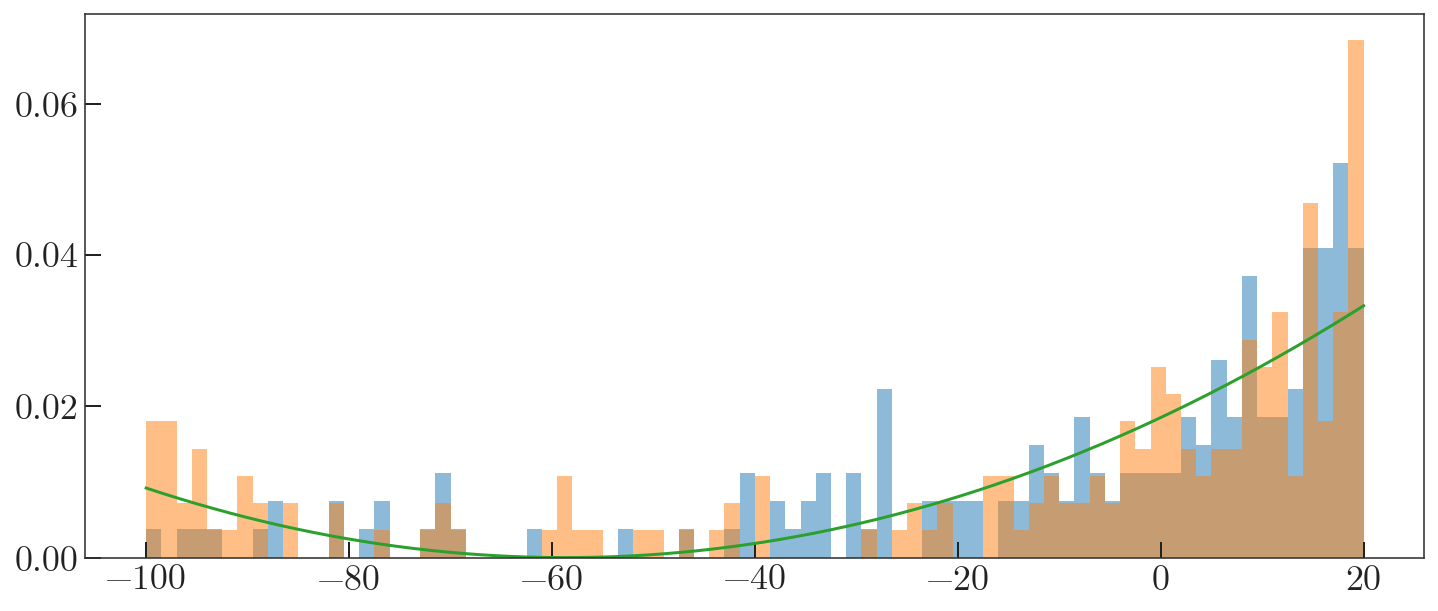

In [115]:
bins = np.arange(-100, 20+1e-3, 1.5)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(phi1[bg_mask1], bins=bins, alpha=0.5, density=True)
ax.hist(phi1[bg_mask2], bins=bins, alpha=0.5, density=True)

x_grid = np.linspace(-100, 20, 1024)
_X = np.stack((x_grid, np.zeros(len(x_grid)))).T

# _p = {'bg_c1': 1e3, 
#       'bg_c2': 0, 
#       'bg_c3': 0, 
#       'bg_x0': -50.}
ln_px2 = -np.log(window_bounds[1][1] - window_bounds[1][0])
_ll = model.bg_ln_likelihood(best_p, _X, window_bounds) - ln_px2 # remove contribution from x2
# _ll = ln_bg_quadratic_uniform(_p, _X, window_bounds)
ax.plot(x_grid, np.exp(_ll), marker='')